#### Purpose : E. MODEL EVALUATION 

In the model evaluation phase, each trained classifier is assessed using a comprehensive set of performance metrics to ensure robustness, reliability, and fairness. Accuracy provides an overall measure of correct predictions, while Precision and Recall offer deeper insights into how well the model handles class-specific errors particularly important for imbalanced datasets. The F1-score combines Precision and Recall into a single harmonic mean, making it ideal when misclassification costs differ across categories. Additionally, ROC-AUC (one-vs-rest) evaluates the model’s ability to distinguish between the three classes across various threshold settings, offering a threshold-independent performance measure. Finally, confusion matrices are generated to visualize class-level prediction patterns, highlight misclassification trends, and support deeper diagnostic analysis. This multi-metric evaluation ensures that model comparison is thorough, interpretable, and aligned with the project’s objective of building a reliable student performance prediction system.

In [1]:
%run 00_project_setup.ipynb
%run 01_data_import.ipynb 
%run 04_feature_engineering.ipynb

c:\Users\User\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%run 05_model_training.ipynb

Original: (4424, 15)
After outlier removal: (4335, 15)

Training SVM...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters for SVM: {'clf__C': 10, 'clf__degree': 2, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Best CV Weighted F1 Score: 0.7490

Training RandomForest...
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters for RandomForest: {'clf__bootstrap': False, 'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}
Best CV Weighted F1 Score: 0.7554

Training XGBoost...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for XGBoost: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 1.0}
Best CV Weighted F1 Score: 0.7575

Training DecisionTree...
Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best parameters for DecisionTree: {'clf__criterion': 'gini', 'clf__max_

In [4]:
# -----------------------------
# Model Evaluation
# -----------------------------
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted"),
        "Recall": recall_score(y_test, y_pred, average="weighted"),
        "F1-score": f1_score(y_test, y_pred, average="weighted"),
        "Confusion_Matrix": confusion_matrix(y_test, y_pred)
    }
    
    # ROC-AUC for multi-class (one-vs-rest)
    if y_prob is not None:
        lb = LabelBinarizer()
        y_test_bin = lb.fit_transform(y_test)
        metrics["ROC-AUC"] = roc_auc_score(y_test_bin, y_prob, average="weighted", multi_class="ovr")
    else:
        metrics["ROC-AUC"] = "Not available"
    
    return metrics


In [5]:

# Evaluate all models
evaluation_results = {}
for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    eval_metrics = evaluate_model(model, X_test, y_test)
    evaluation_results[name] = eval_metrics
    for metric, value in eval_metrics.items():
        print(f"{metric}: {value}")
    print('---------------------------------------------------------------------')


Evaluating SVM...
Accuracy: 0.7589388696655133
Precision: 0.762447198872784
Recall: 0.7589388696655133
F1-score: 0.7505708618667748
Confusion_Matrix: [[176  52  49]
 [ 21  72  64]
 [  4  19 410]]
ROC-AUC: 0.8969766946397549
---------------------------------------------------------------------

Evaluating RandomForest...
Accuracy: 0.7727797001153403
Precision: 0.7630104811825705
Recall: 0.7727797001153403
F1-score: 0.7650755059937466
Confusion_Matrix: [[201  36  40]
 [ 42  69  46]
 [  8  25 400]]
ROC-AUC: 0.9022700550742849
---------------------------------------------------------------------

Evaluating XGBoost...
Accuracy: 0.7877739331026529
Precision: 0.7813337796158661
Recall: 0.7877739331026529
F1-score: 0.7787410610258344
Confusion_Matrix: [[193  38  46]
 [ 31  77  49]
 [  9  11 413]]
ROC-AUC: 0.908729577236649
---------------------------------------------------------------------

Evaluating DecisionTree...
Accuracy: 0.7508650519031141
Precision: 0.7387268344961478
Recall: 0.7508

In [10]:
# Plot Confusion Matrix
# -----------------------------
def plot_confusion_matrix(cm, classes, title="Confusion Matrix", figsize=(6,5)):
    SAVE_PATH = os.path.join("..","outputs", "figures", "confusion_matrix.png")
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title(title)
    plt.savefig(SAVE_PATH , dpi=300 , bbox_inches='tight')
    plt.show()

In [11]:
# -----------------------------
# Plot ROC-AUC for multi-class (one-vs-rest)
# -----------------------------
def plot_roc_auc(model, X_test, y_test, title="ROC-AUC Curve"):
    SAVE_PATH = os.path.join("..","outputs", "figures", "roc_auc.png")
    if not hasattr(model, "predict_proba"):
        print(f"ROC-AUC not available for {model}")
        return
    
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    y_prob = model.predict_proba(X_test)
    n_classes = y_prob.shape[1]
    
    plt.figure(figsize=(8,6))
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {lb.classes_[i]} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(SAVE_PATH , dpi=300 , bbox_inches='tight')  
    plt.show()



Visualizing SVM...


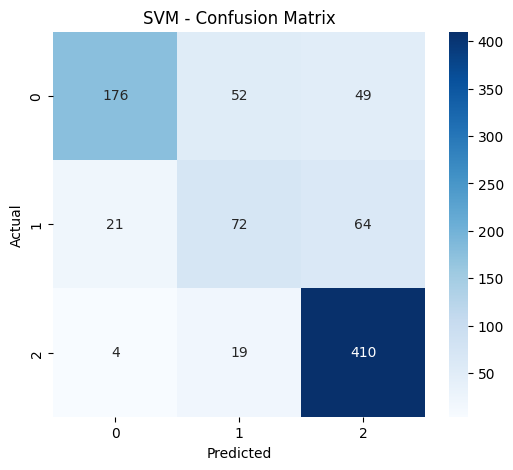

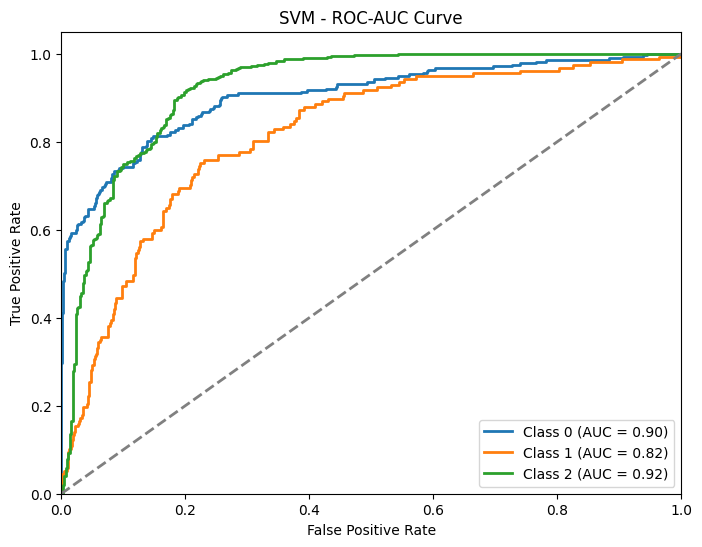


Visualizing RandomForest...


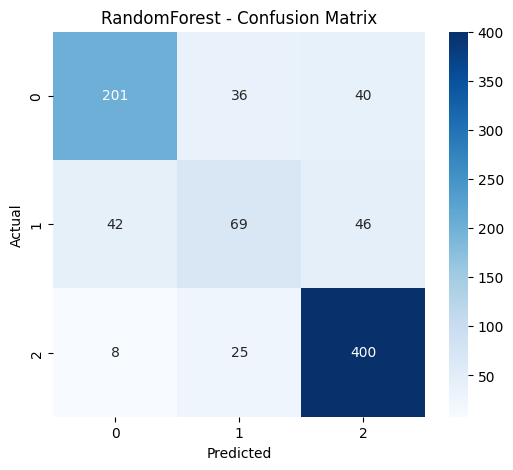

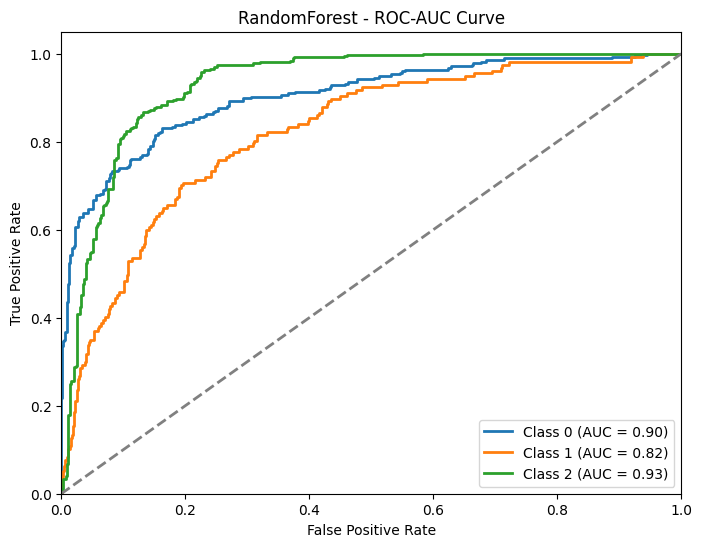


Visualizing XGBoost...


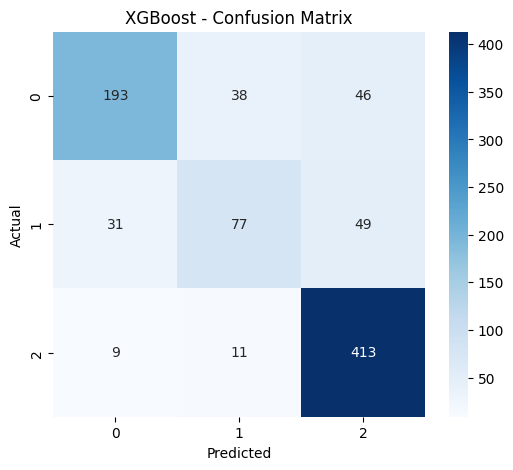

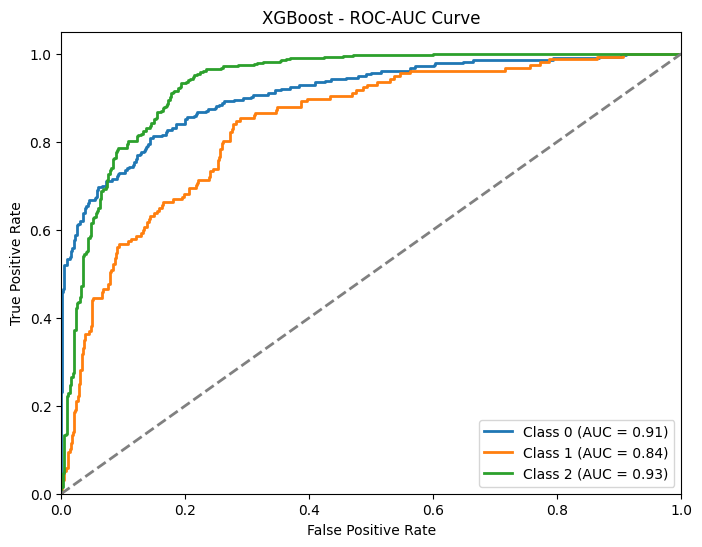


Visualizing DecisionTree...


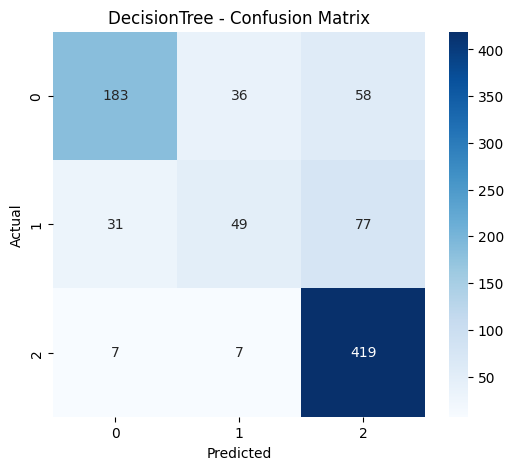

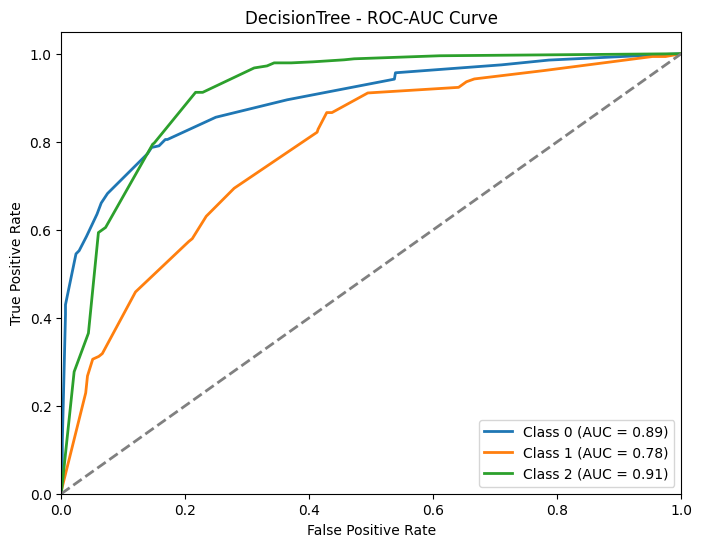


Visualizing LightGBM...


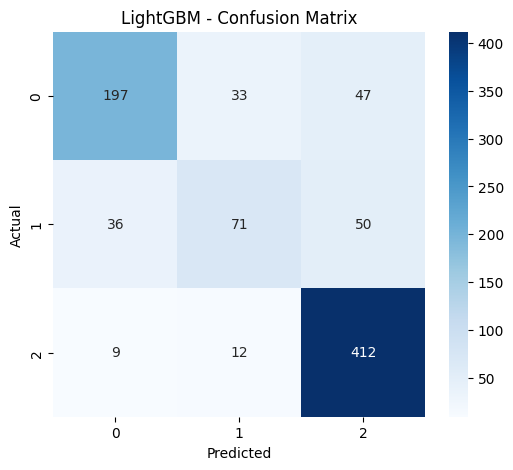

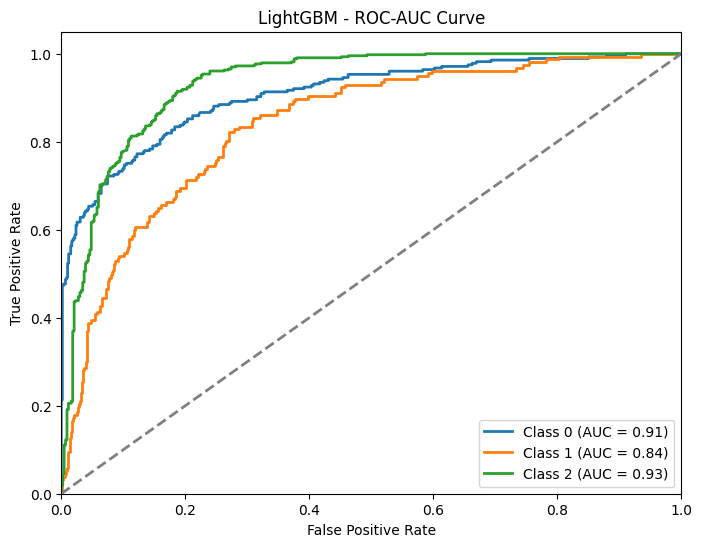

In [12]:
# -----------------------------
# Visualize all models
# -----------------------------
for name, model in best_models.items():
    print(f"\nVisualizing {name}...")
    eval_metrics = evaluation_results[name]
    
    # Confusion Matrix
    plot_confusion_matrix(eval_metrics["Confusion_Matrix"], classes=np.unique(y_test), title=f"{name} - Confusion Matrix")
    
    # ROC-AUC
    plot_roc_auc(model, X_test, y_test, title=f"{name} - ROC-AUC Curve")